In [1]:
import pandas as pd
from main import AiForecast
import numpy as np

# Пути к исходным данным
train_candles_path = "data/candles.csv"
train_news_path = "data/news.csv"

# Загружаем данные
candles = pd.read_csv(train_candles_path, parse_dates=['begin'])
news = pd.read_csv(train_news_path, parse_dates=['publish_date'])

# --- Определяем временные границы ---
train_start = pd.Timestamp("2020-06-19")
train_end   = pd.Timestamp("2025-01-01")

predict_start = pd.Timestamp("2025-01-01")
predict_end   = pd.Timestamp("2025-05-01")   # не включая 2025-05-01

real_start = pd.Timestamp("2025-05-01")
real_end   = pd.Timestamp("2025-05-21")

# --- Создаем выборки для свечей ---
candles_train = candles[(candles['begin'] >= train_start) & (candles['begin'] <= train_end)].copy()
candles_for_predict = candles[(candles['begin'] >= predict_start) & (candles['begin'] < predict_end)].copy()
candles_real_results = candles[(candles['begin'] >= real_start) & (candles['begin'] <= real_end)].copy()

# --- Аналогично для новостей ---
news_train = news[(news['publish_date'] >= train_start) & (news['publish_date'] <= train_end)].copy()
news_for_predict = news[(news['publish_date'] >= predict_start) & (news['publish_date'] < predict_end)].copy()
news_real_results = news[(news['publish_date'] >= real_start) & (news['publish_date'] <= real_end)].copy()



/Users/zahardimidov/Desktop/Finam/finam-x-hse-trade-ai-hack-forecast-solution/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate_submission(submission_df, test_candles_df):
    """
    submission_df: датафрейм с колонками ticker,p1..p20
    test_candles_df: реальные закрытия
    """
    metrics = {}
    for horizon in range(1, 21):
        col = f"p{horizon}"
        true_returns = []
        pred_returns = []
        for ticker in submission_df["ticker"]:
            df_ticker = test_candles_df[
                test_candles_df["ticker"] == ticker
            ].sort_values("begin")
            if len(df_ticker) <= horizon:
                continue
            close_0 = df_ticker.iloc[0]["close"]
            close_h = df_ticker.iloc[horizon]["close"]
            R_true = close_h / close_0 - 1
            R_pred = submission_df[submission_df["ticker"] == ticker][col].values[0]
            true_returns.append(R_true)
            pred_returns.append(R_pred)
        true_returns = np.array(true_returns)
        pred_returns = np.array(pred_returns)
        rmse = np.sqrt(np.mean((true_returns - pred_returns) ** 2))
        metrics[col] = rmse
    return metrics

In [3]:
ai_forecast = AiForecast(artifact_dir='./test_artifact')

ai_forecast.train(candles_train, news_train)
submission = ai_forecast.predict(candles_for_predict, news_for_predict)

submission.to_csv("test_submission.csv", index=False)

====== Training ======
Пустых tickers: 122
Заполненных tickers: 20487
Сдвиг по дате выполнен
Новизна добавлена
Количество удаленных дубликатов: 76


100%|██████████| 439/439 [07:39<00:00,  1.05s/it]


====== Predicting ======
Пустых tickers: 6
Заполненных tickers: 1638
Сдвиг по дате выполнен
Новизна добавлена
['open', 'close', 'high', 'low', 'volume', 'weekday', 'return_1d', 'log_return', 'SMA_3', 'EMA_3', 'volatility_3', 'momentum_3', 'SMA_5', 'EMA_5', 'volatility_5', 'momentum_5', 'SMA_10', 'EMA_10', 'volatility_10', 'momentum_10', 'RSI_7', 'MACD', 'MACD_signal', 'bollinger_upper', 'bollinger_lower', 'bollinger_bandwidth', 'ATR_7', 'volume_mean_3', 'volume_change_3', 'volume_mean_5', 'volume_change_5', 'volume_mean_10', 'volume_change_10', 'distance_from_SMA_3', 'distance_from_SMA_5']


{'p1': np.float64(0.03392649266258556), 'p2': np.float64(0.05537220229565458), 'p3': np.float64(0.0666994826110969), 'p4': np.float64(0.08504199519057434), 'p5': np.float64(0.09942075306478655), 'p6': np.float64(0.11700073606076901), 'p7': np.float64(0.13394213159675702), 'p8': np.float64(0.15661245332300544), 'p9': np.float64(0.17898672259203255), 'p10': np.float64(0.19096167516696838), 'p11': np.float64(0.19513741262595558), 'p12': np.float64(0.21005576437783818), 'p13': np.float64(0.2225870697212201), 'p14': np.float64(0.24502490360128232), 'p15': np.float64(0.264952299530346), 'p16': np.float64(0.2701951063591272), 'p17': np.float64(0.2815864019546091), 'p18': np.float64(0.29340527026475516), 'p19': np.float64(nan), 'p20': np.float64(nan)}


/Users/zahardimidov/Desktop/Finam/finam-x-hse-trade-ai-hack-forecast-solution/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zahardimidov/Desktop/Finam/finam-x-hse-trade-ai-hack-forecast-solution/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


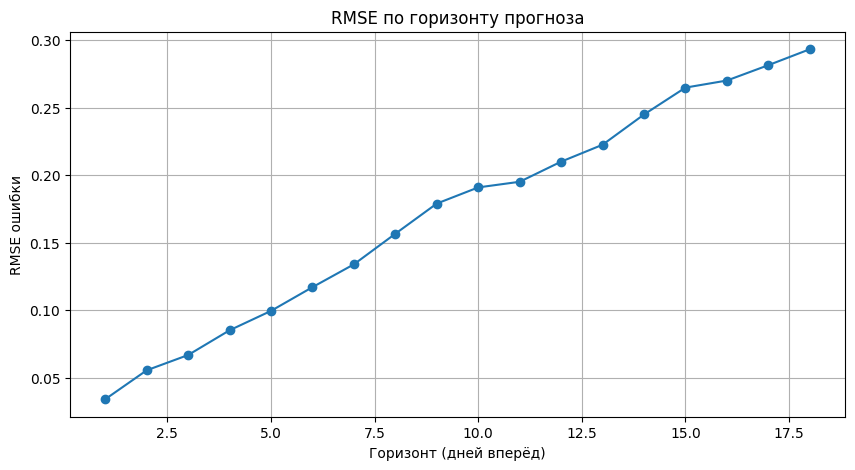

In [4]:
import matplotlib.pyplot as plt

metrics = evaluate_submission(submission, candles_real_results)

print(metrics)

plt.figure(figsize=(10,5))
plt.plot(range(1,21), list(metrics.values()), marker='o')
plt.title('RMSE по горизонту прогноза')
plt.xlabel('Горизонт (дней вперёд)')
plt.ylabel('RMSE ошибки')
plt.grid(True)
plt.show()
